# Zackary Ducreux 
#### P2023
  
# Predictive modeling and unsupervised clustering
## Supervised Learning Project
###  

### Analyse of what is the dataset and first look at the data (images and labels)

Tissue Types 	 Sample Count
________________________________
TUMOR
class 1: TUMOR	 625
________________________________
STROMA
class 2: STROMA	 625
________________________________
COMPLEX
class 3: COMPLEX	 625
________________________________
LYMPHO
class 4: LYMPHO	 625
________________________________
DEBRIS
class 5: DEBRIS	 625
________________________________
MUCOSA
class 6: MUCOSA	 625
________________________________
ADIPOSE
class 7: ADIPOSE	 625
________________________________
EMPTY
class 8: EMPTY	 625
________________________________


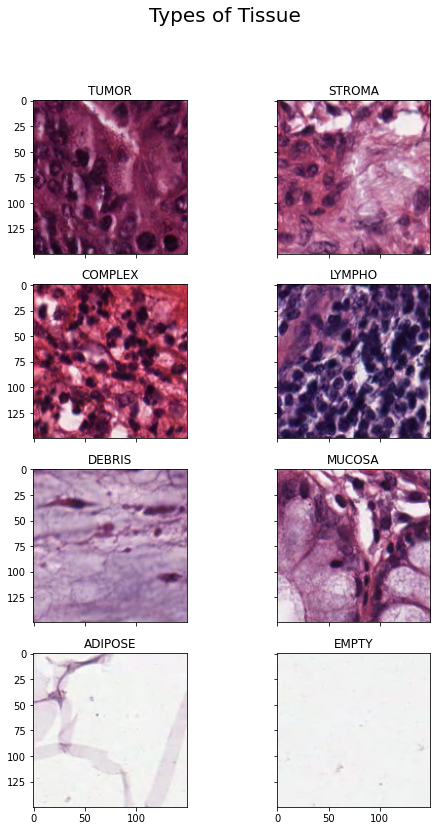

In [64]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

directory = 'Kather_texture_2016_image_tiles_5000'
tissue_im_p = {} # keys: tissue type # Val: Filenames of images

i = 0
for root_dir, dirnames, filenames in os.walk(directory):
    if i == 0:
        print('Tissue Types \t Sample Count')
        
    else:
        tissue_im_p[root_dir.split('/')[-1][3:]] = [os.path.join(root_dir, filenames[k]) for k in range(len(filenames))]
        name = root_dir.split('/')[-1][3:].split("_")[-1]
        print(name)
        print(f"class {i}: {name}\t", len(filenames))
    i += 1
    print('________________________________')
    
# Lets look at an image from each type
rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(8, 13))
fig.suptitle('Types of Tissue', fontsize = 20.0)

for j, tissue in enumerate(tissue_im_p):
    ax = axs[j//cols][j%cols]
    ax.set_title(tissue.split("_")[-1])
    img = np.asarray(Image.open(tissue_im_p[tissue][np.random.randint(0,len(tissue_im_p[tissue]))]))
    ax.imshow(img)

##### As we can see there is 8 different labels composed of 625 pictures each.

##### Imports of the model

In [65]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import pandas as pd
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import tensorflow as tf
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from os import listdir
from os.path import isfile, join, isdir
from sklearn.model_selection import GridSearchCV
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

##### Import the images and transform in a DataFrame

In [66]:
mypath = 'Kather_texture_2016_image_tiles_5000'
onlyfolder = [f for f in listdir(mypath) if isdir(join(mypath, f))]
onlyfolder

['01_TUMOR',
 '02_STROMA',
 '03_COMPLEX',
 '04_LYMPHO',
 '05_DEBRIS',
 '06_MUCOSA',
 '07_ADIPOSE',
 '08_EMPTY']

In [67]:
df_images_labels = pd.DataFrame(columns=['image', 'label'])
current_index = 0
for folder in onlyfolder:
    onlyfiles = [f for f in listdir(f'{mypath}/{folder}') if isfile(join(f'{mypath}/{folder}', f))]
    for file in onlyfiles:  
        img = Image.open(f'{mypath}/{folder}/{file}')
        numpydata = asarray(img).astype('float32')
        new_row = {'image': numpydata, 'label': folder.split("_")[1]}
        new_df = pd.DataFrame([new_row], columns=df_images_labels.columns, index=[current_index])
        df_images_labels = pd.concat([df_images_labels, new_df])
        current_index += 1

##### Shapes and X, Y

In [68]:
img_size = numpydata.shape[0]
numpydata.shape

(150, 150, 3)

In [69]:
df_images_labels.shape

(5000, 2)

In [70]:
X = df_images_labels['image']
y = df_images_labels['label']

In [71]:
X = np.array(list(X.values), dtype=float)

In [72]:
class_names = df_images_labels['label'].unique()
class_names

array(['TUMOR', 'STROMA', 'COMPLEX', 'LYMPHO', 'DEBRIS', 'MUCOSA',
       'ADIPOSE', 'EMPTY'], dtype=object)

## Preprossesing

### Describe and justify any data pre-processing you had to do

First we have to split train and test with the tenserflow function. Then we need to apply a label encode on the labels of the 'y_train' and 'y_test' variable so that the string they represented will be transformed into a number associated with their label.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
lb = LabelEncoder()
y_lb = lb.fit_transform(y_train)

#### Verify the size of test and train dataframes

In [75]:
X_train.shape, y_lb.shape

((4000, 150, 150, 3), (4000,))

In [76]:
X_test.shape, y_test.shape

((1000, 150, 150, 3), (1000,))

## Logs

In [77]:
LOG_DIR = 'logs'

def best_model_path(model_name):
    base_dir  = os.path.join(LOG_DIR, model_name)
    return os.path.join(base_dir, 'best_val_accuracy.ckpt')

def callback_list(model_name):
    base_dir  = os.path.join(LOG_DIR, model_name)
    tb_cb = tf.keras.callbacks.TensorBoard(base_dir)
    ckpt = tf.keras.callbacks.ModelCheckpoint(
         best_model_path(model_name),
         monitor='val_accuracy',
         mode='max', 
         verbose=0,
         save_best_only=True)
    backup_dir = os.path.join(base_dir, 'backup_checkpoint')
    bkp = tf.keras.callbacks.BackupAndRestore(
        backup_dir)
    return [tb_cb, ckpt, bkp]


earlystop = tf.keras.callbacks.EarlyStopping('val_loss', patience=20, restore_best_weights=True)

#### Plot accuracy and loss function 

In [78]:
def plot_learning_curves(history):
    df = pd.DataFrame(history.history, index=np.array(history.epoch)+1)
    df.plot(figsize=(8, 5), fontsize=12)
    plt.grid(True)
    plt.gca().set_ylim(0, 1.2)
    plt.gca().set_xlim(0, 20)
    plt.xlabel('epochs', fontsize=12)
    plt.title ('learning curves', fontsize=12)
    plt.legend(fontsize=12)
    plt.show()

#### Parameters

In [79]:
num_classes = len(class_names)
EPOCHS = 20
input_shape = X_train[0].shape
input_shape, num_classes

((150, 150, 3), 8)

## Models

# Sequential baseline model:

In [80]:
SEED = 123
tf.keras.utils.set_random_seed(SEED)

model_1 = Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(16, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')])

In [81]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 90000)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               11520128  
                                                                 
 dense_9 (Dense)             (None, 8)                 1032      
                                                      

In [82]:
model_1.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [83]:
logs = {}
MODEL_NAME = 'baseline_model'

logs[MODEL_NAME] = model_1.fit(X_train, y_lb, validation_data=(X_test, y_lb_test), 
                             epochs=EPOCHS, callbacks=[callback_list(MODEL_NAME), earlystop])

Epoch 1/20


C:\Users\zducreux\Anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


125/125 [==============================] - ETA: 0s - loss: 2.4930 - accuracy: 0.4425

INFO:tensorflow:Assets written to: logs\baseline_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\baseline_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 24s 182ms/step - loss: 2.4930 - accuracy: 0.4425 - val_loss: 0.9030 - val_accuracy: 0.6970
Epoch 2/20
125/125 [==============================] - 21s 169ms/step - loss: 0.7973 - accuracy: 0.6693 - val_loss: 0.8418 - val_accuracy: 0.5970
Epoch 3/20
125/125 [==============================] - 20s 160ms/step - loss: 0.6399 - accuracy: 0.7545 - val_loss: 0.8435 - val_accuracy: 0.6510
Epoch 4/20
125/125 [==============================] - ETA: 0s - loss: 0.5584 - accuracy: 0.7837

INFO:tensorflow:Assets written to: logs\baseline_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\baseline_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 21s 171ms/step - loss: 0.5584 - accuracy: 0.7837 - val_loss: 0.8235 - val_accuracy: 0.7110
Epoch 5/20
125/125 [==============================] - ETA: 0s - loss: 0.3989 - accuracy: 0.8687

INFO:tensorflow:Assets written to: logs\baseline_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\baseline_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 21s 171ms/step - loss: 0.3989 - accuracy: 0.8687 - val_loss: 0.7216 - val_accuracy: 0.7200
Epoch 6/20
125/125 [==============================] - 20s 159ms/step - loss: 0.3718 - accuracy: 0.8737 - val_loss: 0.8088 - val_accuracy: 0.6750
Epoch 7/20
125/125 [==============================] - 21s 170ms/step - loss: 0.2917 - accuracy: 0.9087 - val_loss: 0.8306 - val_accuracy: 0.6710
Epoch 8/20
125/125 [==============================] - ETA: 0s - loss: 0.2009 - accuracy: 0.9460

INFO:tensorflow:Assets written to: logs\baseline_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\baseline_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 24s 190ms/step - loss: 0.2009 - accuracy: 0.9460 - val_loss: 0.8310 - val_accuracy: 0.7270
Epoch 9/20
125/125 [==============================] - 19s 155ms/step - loss: 0.1415 - accuracy: 0.9655 - val_loss: 0.8240 - val_accuracy: 0.7230
Epoch 10/20
125/125 [==============================] - 19s 156ms/step - loss: 0.1370 - accuracy: 0.9668 - val_loss: 0.8254 - val_accuracy: 0.7190
Epoch 11/20
125/125 [==============================] - 20s 158ms/step - loss: 0.0837 - accuracy: 0.9822 - val_loss: 0.9367 - val_accuracy: 0.6260
Epoch 12/20
125/125 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.9740

INFO:tensorflow:Assets written to: logs\baseline_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\baseline_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 21s 165ms/step - loss: 0.0947 - accuracy: 0.9740 - val_loss: 0.8242 - val_accuracy: 0.7350
Epoch 13/20
125/125 [==============================] - 21s 169ms/step - loss: 0.0774 - accuracy: 0.9787 - val_loss: 1.0645 - val_accuracy: 0.6550
Epoch 14/20
125/125 [==============================] - 20s 157ms/step - loss: 0.1769 - accuracy: 0.9420 - val_loss: 1.0566 - val_accuracy: 0.6640
Epoch 15/20
125/125 [==============================] - 19s 156ms/step - loss: 0.1241 - accuracy: 0.9647 - val_loss: 0.9271 - val_accuracy: 0.6970
Epoch 16/20
125/125 [==============================] - 19s 153ms/step - loss: 0.0772 - accuracy: 0.9778 - val_loss: 1.0148 - val_accuracy: 0.7060
Epoch 17/20
125/125 [==============================] - 19s 153ms/step - loss: 0.1004 - accuracy: 0.9732 - val_loss: 1.2453 - val_accuracy: 0.6420
Epoch 18/20
125/125 [==============================] - 19s 154ms/step - loss: 0.0793 - accuracy: 0.9800 - val_loss: 0.9983 - val_accurac

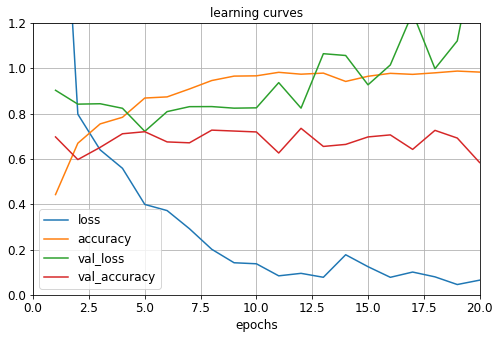

In [84]:
plot_learning_curves(logs['baseline_model'])

### This model is overfitting as we can see with the Val_loss that is incresing instead of following the curve of the loss of the training.

# Sequential developped model:

In [85]:
SEED = 123
tf.keras.utils.set_random_seed(SEED)

model_2 = Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(64, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')])

In [86]:
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 37, 37, 128)      

In [87]:
model_2.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [88]:
logs = {}
MODEL_NAME = 'developed_model'

logs[MODEL_NAME] = model_2.fit(X_train, y_lb, validation_data=(X_test, y_lb_test), 
                             epochs=EPOCHS, callbacks=[callback_list(MODEL_NAME), earlystop])

Epoch 1/20


C:\Users\zducreux\Anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


125/125 [==============================] - ETA: 0s - loss: 1.4570 - accuracy: 0.3515

INFO:tensorflow:Assets written to: logs\developed_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 115s 912ms/step - loss: 1.4570 - accuracy: 0.3515 - val_loss: 1.0154 - val_accuracy: 0.5490
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.9571 - accuracy: 0.5630

INFO:tensorflow:Assets written to: logs\developed_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 139s 1s/step - loss: 0.9571 - accuracy: 0.5630 - val_loss: 0.8169 - val_accuracy: 0.6980
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.8005 - accuracy: 0.6658

INFO:tensorflow:Assets written to: logs\developed_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 115s 925ms/step - loss: 0.8005 - accuracy: 0.6658 - val_loss: 0.7004 - val_accuracy: 0.7310
Epoch 4/20
125/125 [==============================] - ETA: 0s - loss: 0.7621 - accuracy: 0.6970

INFO:tensorflow:Assets written to: logs\developed_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 115s 921ms/step - loss: 0.7621 - accuracy: 0.6970 - val_loss: 0.6522 - val_accuracy: 0.7500
Epoch 5/20
125/125 [==============================] - 112s 896ms/step - loss: 0.7062 - accuracy: 0.7255 - val_loss: 0.8354 - val_accuracy: 0.6500
Epoch 6/20
125/125 [==============================] - 112s 897ms/step - loss: 0.6121 - accuracy: 0.7588 - val_loss: 0.6938 - val_accuracy: 0.7270
Epoch 7/20
125/125 [==============================] - ETA: 0s - loss: 0.5463 - accuracy: 0.7940

INFO:tensorflow:Assets written to: logs\developed_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 115s 922ms/step - loss: 0.5463 - accuracy: 0.7940 - val_loss: 0.5589 - val_accuracy: 0.7960
Epoch 8/20
125/125 [==============================] - 113s 904ms/step - loss: 0.4812 - accuracy: 0.8210 - val_loss: 0.6291 - val_accuracy: 0.7750
Epoch 9/20
125/125 [==============================] - ETA: 0s - loss: 0.4790 - accuracy: 0.8250

INFO:tensorflow:Assets written to: logs\developed_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 115s 921ms/step - loss: 0.4790 - accuracy: 0.8250 - val_loss: 0.4588 - val_accuracy: 0.8300
Epoch 10/20
125/125 [==============================] - 114s 914ms/step - loss: 0.4304 - accuracy: 0.8275 - val_loss: 0.5253 - val_accuracy: 0.8070
Epoch 11/20
125/125 [==============================] - 112s 900ms/step - loss: 0.3790 - accuracy: 0.8510 - val_loss: 0.4862 - val_accuracy: 0.8230
Epoch 12/20
125/125 [==============================] - ETA: 0s - loss: 0.3808 - accuracy: 0.8485

INFO:tensorflow:Assets written to: logs\developed_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 116s 926ms/step - loss: 0.3808 - accuracy: 0.8485 - val_loss: 0.4562 - val_accuracy: 0.8320
Epoch 13/20
125/125 [==============================] - 112s 899ms/step - loss: 0.3467 - accuracy: 0.8692 - val_loss: 0.5120 - val_accuracy: 0.8290
Epoch 14/20
125/125 [==============================] - 114s 914ms/step - loss: 0.3241 - accuracy: 0.8823 - val_loss: 0.5562 - val_accuracy: 0.8150
Epoch 15/20
125/125 [==============================] - 116s 925ms/step - loss: 0.2555 - accuracy: 0.9038 - val_loss: 0.5835 - val_accuracy: 0.8170
Epoch 16/20
125/125 [==============================] - 115s 921ms/step - loss: 0.2829 - accuracy: 0.8890 - val_loss: 0.6449 - val_accuracy: 0.8080
Epoch 17/20
125/125 [==============================] - 115s 917ms/step - loss: 0.2216 - accuracy: 0.9175 - val_loss: 0.5467 - val_accuracy: 0.8250
Epoch 18/20
125/125 [==============================] - 116s 927ms/step - loss: 0.1722 - accuracy: 0.9385 - val_loss: 0.6279 - val_

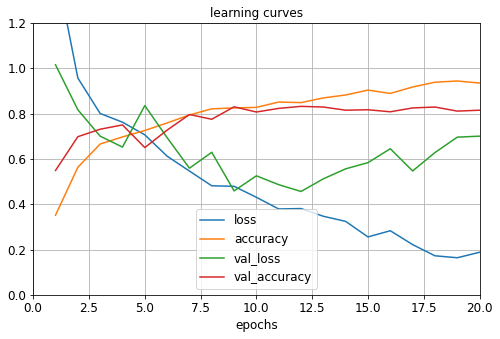

In [89]:
plot_learning_curves(logs['developed_model'])

# Sequential developped optimized  model:

#### Data augmentation (flip, zoom, rotation)

In [90]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1, 0.1),
  ]
)

In [91]:
SEED = 123
tf.keras.utils.set_random_seed(SEED)

model_3 = Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),
    data_augmentation,
    layers.Conv2D(64, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding="same"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')])

In [92]:
model_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 sequential_6 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                 

In [93]:
model_3.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [94]:
logs = {}
MODEL_NAME = 'developed_optimized_model'

logs[MODEL_NAME] = model_3.fit(X_train, y_lb, validation_data=(X_test, y_lb_test), 
                             epochs=EPOCHS, callbacks=[callback_list(MODEL_NAME), earlystop])

Epoch 1/20


C:\Users\zducreux\Anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


125/125 [==============================] - ETA: 0s - loss: 1.4349 - accuracy: 0.3593WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 142s 1s/step - loss: 1.4349 - accuracy: 0.3593 - val_loss: 1.1842 - val_accuracy: 0.4620
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 1.0627 - accuracy: 0.5210WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 135s 1s/step - loss: 1.0627 - accuracy: 0.5210 - val_loss: 0.8777 - val_accuracy: 0.6560
Epoch 3/20
125/125 [==============================] - 122s 978ms/step - loss: 0.8548 - accuracy: 0.6465 - val_loss: 0.9200 - val_accuracy: 0.6210
Epoch 4/20
125/125 [==============================] - ETA: 0s - loss: 0.7817 - accuracy: 0.6795WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 139s 1s/step - loss: 0.7817 - accuracy: 0.6795 - val_loss: 0.6889 - val_accuracy: 0.7330
Epoch 5/20
125/125 [==============================] - ETA: 0s - loss: 0.7161 - accuracy: 0.7168WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 139s 1s/step - loss: 0.7161 - accuracy: 0.7168 - val_loss: 0.6666 - val_accuracy: 0.7360
Epoch 6/20
125/125 [==============================] - ETA: 0s - loss: 0.6234 - accuracy: 0.7605WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 135s 1s/step - loss: 0.6234 - accuracy: 0.7605 - val_loss: 0.6107 - val_accuracy: 0.7740
Epoch 7/20
125/125 [==============================] - 122s 979ms/step - loss: 0.5890 - accuracy: 0.7818 - val_loss: 0.6540 - val_accuracy: 0.7490
Epoch 8/20
125/125 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.7650WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 139s 1s/step - loss: 0.6166 - accuracy: 0.7650 - val_loss: 0.5655 - val_accuracy: 0.7980
Epoch 9/20
125/125 [==============================] - 127s 1s/step - loss: 0.5510 - accuracy: 0.7950 - val_loss: 0.5638 - val_accuracy: 0.7930
Epoch 10/20
125/125 [==============================] - 124s 992ms/step - loss: 0.5726 - accuracy: 0.7847 - val_loss: 0.5632 - val_accuracy: 0.7970
Epoch 11/20
125/125 [==============================] - ETA: 0s - loss: 0.5188 - accuracy: 0.8052WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 139s 1s/step - loss: 0.5188 - accuracy: 0.8052 - val_loss: 0.4764 - val_accuracy: 0.8220
Epoch 12/20
125/125 [==============================] - ETA: 0s - loss: 0.4936 - accuracy: 0.8183WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 133s 1s/step - loss: 0.4936 - accuracy: 0.8183 - val_loss: 0.4587 - val_accuracy: 0.8300
Epoch 13/20
125/125 [==============================] - 121s 970ms/step - loss: 0.4699 - accuracy: 0.8207 - val_loss: 0.5152 - val_accuracy: 0.8280
Epoch 14/20
125/125 [==============================] - 123s 984ms/step - loss: 0.4635 - accuracy: 0.8275 - val_loss: 0.6059 - val_accuracy: 0.7880
Epoch 15/20
125/125 [==============================] - 123s 986ms/step - loss: 0.4474 - accuracy: 0.8260 - val_loss: 0.4805 - val_accuracy: 0.8280
Epoch 16/20
125/125 [==============================] - 123s 982ms/step - loss: 0.4659 - accuracy: 0.8225 - val_loss: 0.4512 - val_accuracy: 0.8260
Epoch 17/20
125/125 [==============================] - ETA: 0s - loss: 0.4227 - accuracy: 0.8430WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


INFO:tensorflow:Assets written to: logs\developed_optimized_model\best_val_accuracy.ckpt\assets


125/125 [==============================] - 138s 1s/step - loss: 0.4227 - accuracy: 0.8430 - val_loss: 0.4000 - val_accuracy: 0.8600
Epoch 18/20
125/125 [==============================] - 118s 946ms/step - loss: 0.4020 - accuracy: 0.8485 - val_loss: 0.4409 - val_accuracy: 0.8480
Epoch 19/20
125/125 [==============================] - 121s 968ms/step - loss: 0.3797 - accuracy: 0.8558 - val_loss: 0.4016 - val_accuracy: 0.8520
Epoch 20/20
125/125 [==============================] - 121s 966ms/step - loss: 0.3926 - accuracy: 0.8487 - val_loss: 0.3873 - val_accuracy: 0.8580


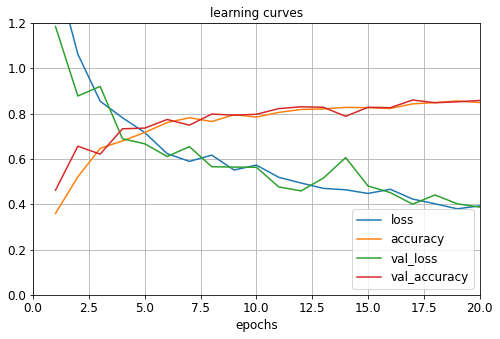

In [95]:
plot_learning_curves(logs['developed_optimized_model'])

## GridSearchCV

In [100]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import svm
from sklearn.neural_network import MLPClassifier


# define the grid search parameters
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'batch_size' : [10, 20, 40, 60, 80, 100]}

clf = MLPClassifier(solver='lbfgs', alpha=1, tol=5e-3)



grid = GridSearchCV(estimator=clf, param_grid=parameter_space, n_jobs=-1)

In [102]:
grid.fit(X_train, y_lb) 

OSError: [WinError 0] L’opération a réussi

In [101]:
best_model = grid.best_params_
best_model

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

# References
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
https://www.kaggle.com/code/hectorlopezhernandez/colorectalhistologymodel-cnn?scriptVersionId=111780293
https://medium.com/@ashraf.dasa/tensorflow-image-classification-of-colorectal-cancer-histology-92-5-accuracy-8b8b40ac775a